<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Py_trodes/PyTrodes_Pipeline_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
New Python Based Pipeline for Trodes
"""

'\nNew Python Based Pipeline for Trodes\n'

In [2]:
""" Generate RAW_LFP Binaries from *.rec files"""
""" Import RAW_LFP """
""" Import XY_position Data """
""" Find Ripples """
""" Map Channels """
""" Finde APs """
""" Find IIS """


' Find IIS '

In [3]:
import os
import subprocess
import numpy as np
trodes_dat_reader_loc = 'C:/Users/dennis.tabuena/Desktop/_SPIKE_GADGETS/Trodes_2-5-1_Windows64/Trodes_2-5-1_Windows64/Resources/TrodesToPython'
os.chdir(trodes_dat_reader_loc)
import readTrodesExtractedDataFile3 as trodes



def read_npy_metadata(npy_filename):
    with open(npy_filename, 'rb') as f:
        version = np.lib.format.read_magic(f)
        np.lib.format._check_version(version)
        shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
        offset = f.tell()
    return shape, dtype, offset

def load_npy_to_memmap(npy_filename):
    shape, dtype, offset = read_npy_metadata(npy_filename)
    return np.memmap(npy_filename, dtype=dtype, mode='r', offset=offset, shape=shape)

def display_filter(fir_coeff,rate):
    # Plot the frequency response of the filter
    w, h = sci.signal.freqz(fir_coeff, worN=8000)
    fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=300)
    ax[0].plot(fir_coeff)
    ax[0].set_title('Coefficients')
    ax[1].plot(0.5 * rate * w / np.pi, np.abs(h), 'b')
    ax[1].set_title('FIR Filter Frequency Response')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Gain')
    plt.grid()
    plt.show()



In [4]:
""" Generate RAW_LFP Binaries from *.rec files"""
dest_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA'
export_func_location = r'C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\trodesexport.exe'
dot_rec_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\Test_Emily\AngelfoodCake01\AngelfoodCake01.rec'
full_cmd_raw = ' '.join([export_func_location, '-raw',
                    '-rec ', dot_rec_file_loc,
                    '-userawrefs', str(0),
                    '-outputdirectory', dest_dir])
# export_report = subprocess.run(full_cmd_raw)



In [5]:
""" Import RAW_LFP """
my_analysis_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze'

dot_dat_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA\AngelfoodCake01.raw\AngelfoodCake01.raw_group0.dat'
animal_session = os.path.basename(dot_rec_file_loc).replace('.rec','')
dot_dat_data = trodes.readTrodesExtractedDataFile(dot_dat_file_loc)
voltage_scaling = float(dot_dat_data['voltage_scaling'])
default_sample_rate = dot_dat_data['clockrate']
num_samples = dot_dat_data['data']['voltage'].shape[0]
num_channels = dot_dat_data['data']['voltage'].shape[1]

os.chdir(r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze')

memmap_filename = os.path.join(my_analysis_dir,'lfp_disk_array.dat')
lfp_disk_array = np.memmap(memmap_filename, dtype='float16', mode='w+', shape=(num_samples,num_channels))
lfp_disk_array = dot_dat_data['data']['voltage'].astype('float16')
lfp_disk_array*=voltage_scaling
raw_npy_filename = os.path.join(my_analysis_dir,animal_session+'_raw_lfp.npy')
np.save(raw_npy_filename, lfp_disk_array)


In [10]:
dot_dat_data['data']=np.nan

In [14]:
"""
DOWN SAMPLE & SAVE
"""
lfp_disk_array = load_npy_to_memmap(raw_npy_filename)
default_sample_rate = 30000
downsampled_rate = 5000
downsample_factor = default_sample_rate/downsampled_rate
downsample_indicies = np.arange(0,lfp_disk_array.shape[0],downsample_factor,dtype='int')
ds_array=lfp_disk_array[downsample_indicies,:]
downsamp_npy_filename = raw_npy_filename.replace('raw', 'downsamp')
np.save(downsamp_npy_filename, ds_array)
del(ds_array)
np.save(animal_session+'_downsampled_rate.npy',downsampled_rate)


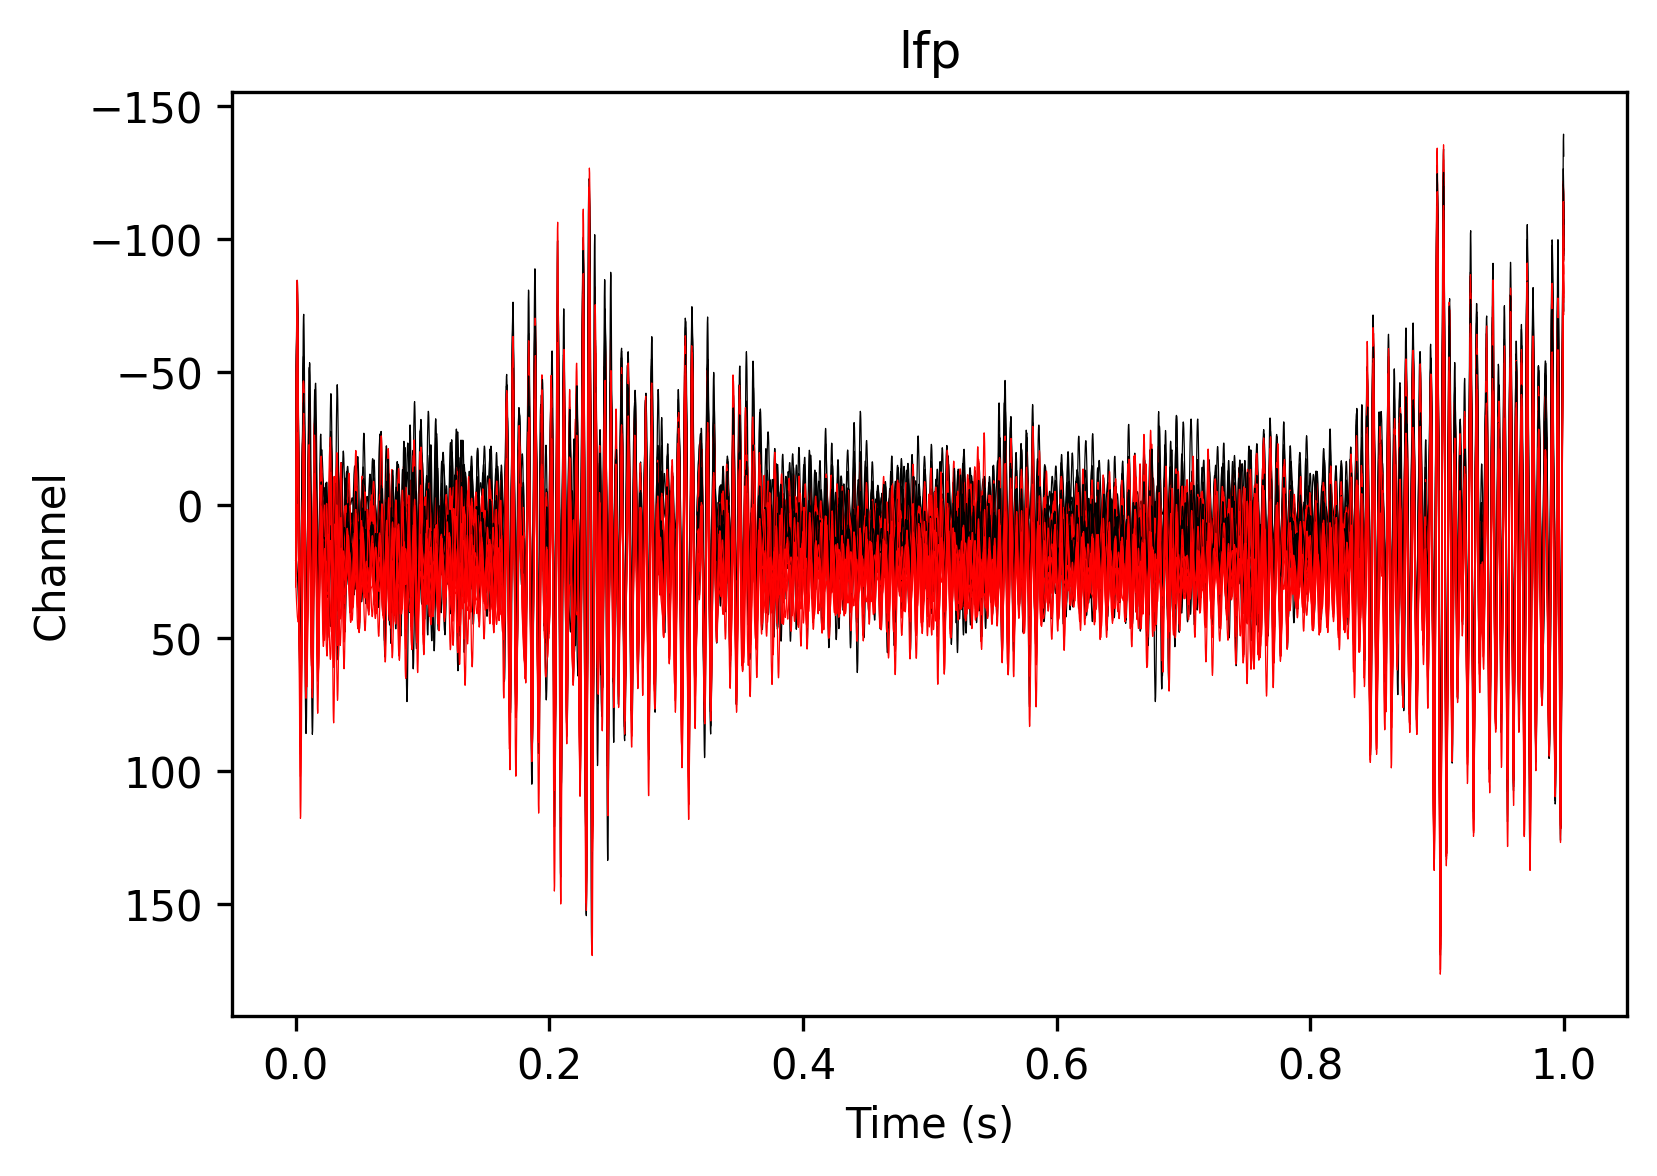

In [71]:
"""
BAND PASS FOR RIPPLES
"""
import scipy as sci
import matplotlib.pyplot as plt
lfp_disk_array = load_npy_to_memmap(downsamp_npy_filename)
downsampled_rate = int(np.load(animal_session+'_downsampled_rate.npy'))
passband = [150, 250] #(150-250 Hz)
num_coefficients = 1200
fir_coeff = sci.signal.firwin(num_coefficients, passband, width=10, window='hamming', pass_zero='bandpass', scale=True, fs=downsampled_rate)

''' Apply the FIR filter using filtfilt for zero-phase filtering across all channels '''
lfp_disk_array = sci.signal.filtfilt(fir_coeff, 1.0, lfp_disk_array, axis=0).astype('float16')
ripfilt_npy_filename = downsamp_npy_filename.replace('downsamp', 'ripfilt')
np.save(ripfilt_npy_filename, lfp_disk_array)
plot_sample_wave(lfp_disk_array,downsampled_rate)

In [79]:
# plot_sample_wave(lfp_disk_array,downsampled_rate)
lfp_disk_array[:300]

array([[ 2.4681e-03, -1.2856e-02, -2.3376e-02, ...,  2.4166e-03,
        -1.1238e-02,  4.0680e-02],
       [ 2.0484e+01,  1.9359e+01,  1.7219e+01, ...,  7.5430e+00,
         1.1734e+01,  1.3250e+01],
       [ 3.9750e+01,  3.7562e+01,  3.3375e+01, ...,  1.4570e+01,
         2.2828e+01,  2.5734e+01],
       ...,
       [ 4.8359e+00,  7.6211e+00,  3.1055e+00, ...,  6.6484e+00,
         7.8906e+00,  7.6289e+00],
       [ 3.2617e+00,  5.2891e+00,  3.7930e+00, ...,  6.5234e+00,
         1.0383e+01,  7.9805e+00],
       [ 1.9443e+00,  2.8652e+00,  4.2539e+00, ...,  6.0117e+00,
         1.2305e+01,  7.9297e+00]], dtype=float16)

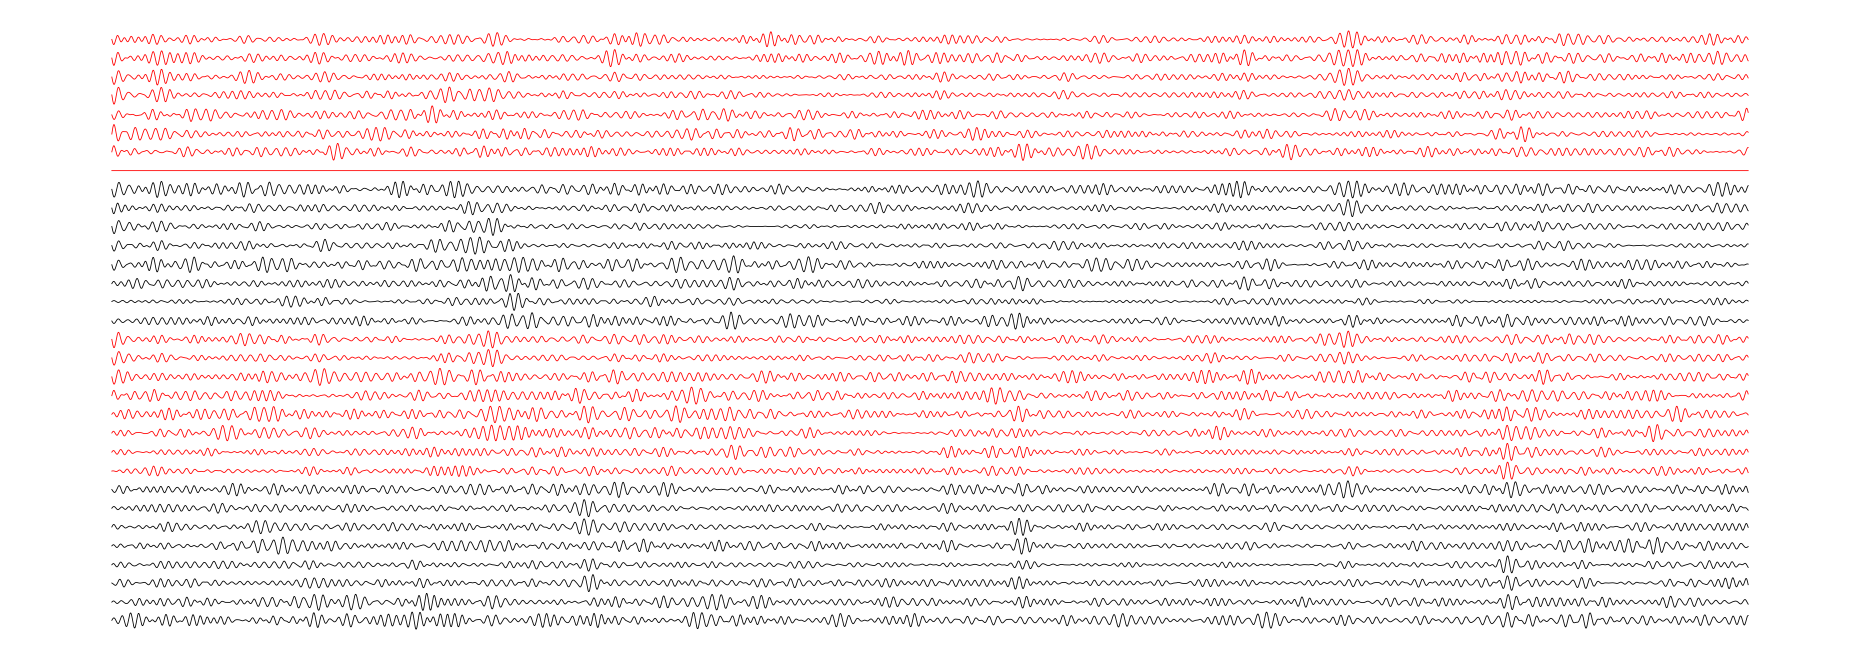

In [85]:
def plot_sample_wave(lfp,sample_rate,times=[0,1]):
    colors = ['k']*8 + ['r']*8 + ['k']*8 + ['r']*8
    tic_indicies = np.arange(times[0]*sample_rate,times[1]*sample_rate)
    time_sec = tic_indicies/sample_rate
    waveform = lfp[tic_indicies,:]
    # waveform = waveform - np.expand_dims(np.mean(waveform,axis=1),axis=-1)
    waveform = waveform - np.expand_dims(waveform[:,24],axis=-1)
    num_chan = waveform.shape[1]
    fig,ax=plt.subplots(num_chan,1,figsize=(6,2),dpi=300)
    for ch in np.arange(num_chan):
        ax[ch].plot(time_sec,waveform[:,ch],linewidth=.2,color=colors[ch])
        ax[ch].set_position([0,ch/num_chan,1,1/num_chan])
        ax[ch].axis('off')
        # ax.plot(time_sec,-waveform[:,ch]+ch,linewidth=.3,color = colors[ch])
        # ax.set_title('lfp')
    # ax.set_ylabel('Channel')
    # ax.set_xlabel('Time (s)')

plot_sample_wave(lfp_disk_array,downsampled_rate)

In [52]:
"""
Ripple Detection
"""
lfp_disk_array = load_npy_to_memmap(ripfilt_npy_filename)
lfp_disk_array = np.abs(sci.signal.hilbert(lfp_disk_array,axis=0)).astype('float16')
gauss_width_ms = 4
sigma = gauss_width_ms/1000*downsampled_rate
filter_width_sigmas = 8
lfp_disk_array  = sci.ndimage.gaussian_filter1d(lfp_disk_array.astype('float32'),
                                                sigma, axis=0, mode='reflect',
                                                truncate=filter_width_sigmas).astype('float16')
lfp_disk_array = (lfp_disk_array - np.mean(lfp_disk_array,axis=0)) / np.std(lfp_disk_array,axis=0)
rip_envl_npy_filename = ripfilt_npy_filename.replace('ripfilt', 'rip_envl')
np.save(rip_envl_npy_filename, lfp_disk_array.astype('float16'))
""" START HERE FOR RIPPLE Triggering """

In [67]:
print(lfp_disk_array)

(21922734, 32)


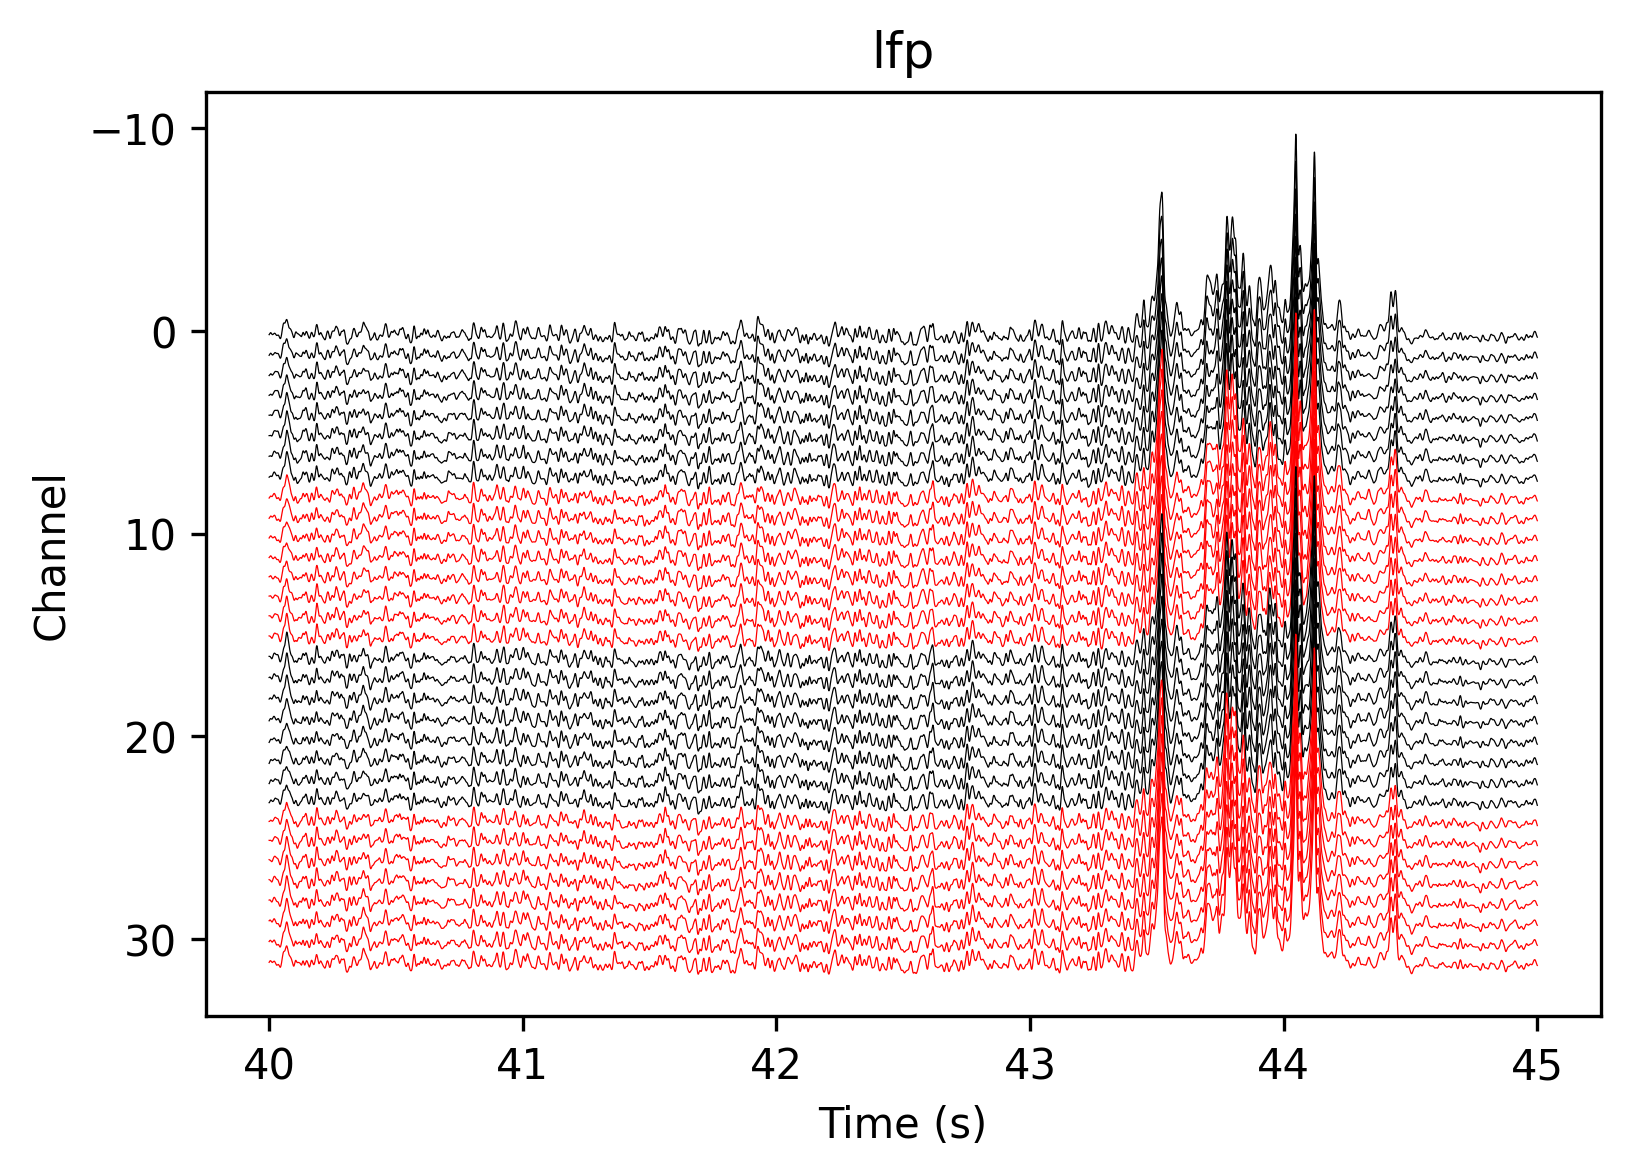

In [65]:
plot_sample_wave(lfp_disk_array,downsampled_rate,times=[40,45])